In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t, norm, binom, rankdata
from sklearn.linear_model import LinearRegression

# Enter 2 columns of B (before), A (after)
dt = {'Test':    [676,206,230,256,280,433,337,466,497,512,794,428,452,512], 
      'Control': [88,570,605,617,653,2913,924,286,1098,982,2346,321,615,519]}

df = pd.DataFrame(dt)
df.drop(index=df[df['Test']==df['Control']].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df['Difference'] = df.apply(lambda X: X['Test'] - X['Control'], axis=1)
df['Sign'] = df['Difference'].apply(lambda d: 1 if d > 0 else -1)
df['Signed Rank'] = rankdata(abs(df.Difference)) * df.Sign
df

,Test,Control,Difference,Sign,Signed Rank
0,676,88,588,1,11.0
1,206,570,-364,-1,-6.0
2,230,605,-375,-1,-8.0
3,256,617,-361,-1,-5.0
4,280,653,-373,-1,-7.0
5,433,2913,-2480,-1,-14.0
6,337,924,-587,-1,-10.0
7,466,286,180,1,4.0
8,497,1098,-601,-1,-12.0
9,512,982,-470,-1,-9.0


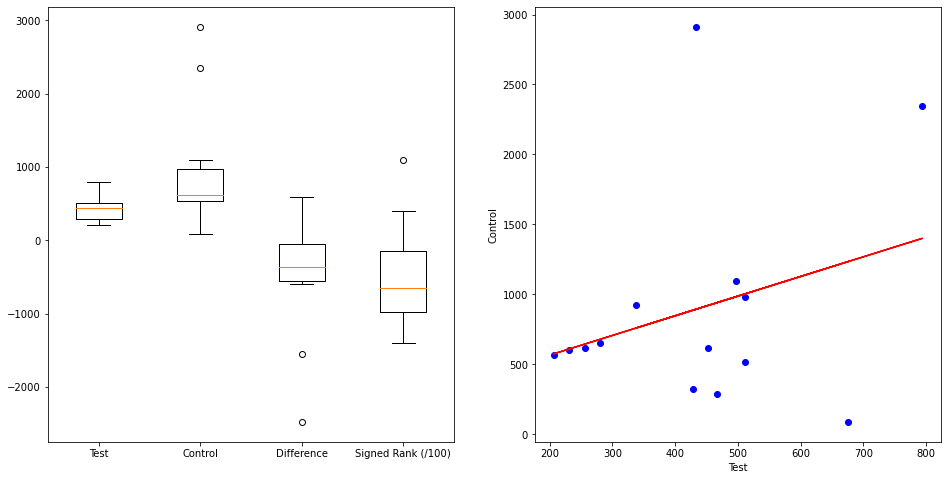

In [2]:
w, h = 2, 1
fig, axes = plt.subplots(h, w, figsize=(16, 8))

axes[0].boxplot([df['Test'], df['Control'], df['Difference'], df['Signed Rank'] * 100],
                labels=['Test', 'Control', 'Difference', 'Signed Rank (/100)'])
axes[1].scatter(df['Test'], df['Control'], color='b')
axes[1].set_xlabel('Test')
axes[1].set_ylabel('Control')

model = LinearRegression()
model.fit(df['Test'].values.reshape(-1,1), df['Control'].values.reshape(-1,1))
Y = model.predict(df['Test'].values.reshape(-1,1))
axes[1].plot(df['Test'], Y, color='r')

plt.show()

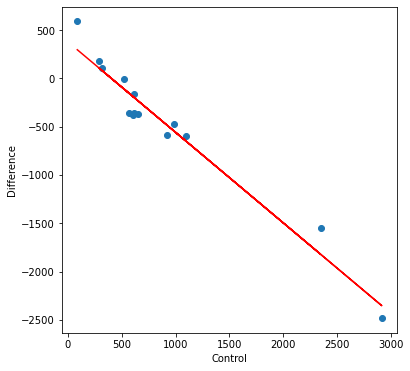

In [3]:
plt.gcf().set_size_inches(6,6)
plt.scatter(df.Control, df.Difference)
plt.ylabel('Difference')
plt.xlabel('Control')
model = LinearRegression()
model.fit(df['Control'].values.reshape(-1,1), df['Difference'].values.reshape(-1,1))
Y = model.predict(df['Control'].values.reshape(-1,1))
plt.plot(df['Control'], Y, color='r')

plt.show()

#### 1. Difference Test

In [4]:
''' Establish hypothesis, set significant level, and the test statistics
    H0: mu_D = 0 vs. Ha: mu_D < 0 , where mu_D = Test - Control
    T = |mu_D - mean| / std_error
    Compute the degree of freedoms, define one tail/two tails alternative.
''' 
alpha, ddof = 0.05, len(df) - 1
two_tails = False

# Compute the t statistic value
if two_tails:
    t_alpha = t.ppf(1 - alpha/2, ddof) 
else:
    t_alpha = t.ppf(1 - alpha, ddof) 

round(t_alpha, 3)

1.771

In [5]:
# The sample mean, std error of Difference is normally distributed, hence
mean = df['Difference'].mean()
std_ = df['Difference'].std() / (len(df))**0.5
round(mean, 3), round(std_, 3)

(-461.286, 202.533)

In [6]:
# Compute the (1 - alpha) * 100% confidence interval
ci = (mean - t_alpha * std_, mean + t_alpha * std_)
round(ci[0], 3), round(ci[1], 3)

(-819.958, -102.613)

In [7]:
# Asumme H0, then Difference = 0, compute the t statistic:
t_null = abs(mean) / std_
round(t_null, 3), ddof

(2.278, 13)

In [8]:
# Evaluate the rejection of H0
if t_null > t_alpha:
    print('The test statistic is statistically significant. H0 should be rejected!')
else:
    print('The test statistic is not statistically significant. H0 cannot be rejected!')

The test statistic is statistically significant. H0 should be rejected!


In [9]:
p_value = 1 - t.cdf(t_null, ddof)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.02


In [10]:
# Other way to compute the p_value using the survival function of stats
p_value = t.sf(t_null, ddof)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.02


#### 2. Signed Rank Test

In [11]:
''' Establish hypothesis, set significant level, and the test statistics
    H0:  mu_D < 0 vs. Ha: mu_D < 0 , where mu_D = Test - Control
    T = sum of postive Signed_Rank
    Compute the degree of freedoms, define one tail/two tails alternative.
''' 

# Set significant level alpha, one tail or two tails.
alpha = 0.05
two_tails = False

# Compute the Z statistic value
if two_tails:
    Z_alpha = norm.ppf(1 - alpha/2) 
else:
    Z_alpha = norm.ppf(1 - alpha) 

round(Z_alpha, 3)

1.645

In [12]:
# Compute the mean and std of the rank under assumption of H0
n = len(df)
mean = n * (n + 1) / 4
std_ = (mean * (2 * n + 1) / 6)**0.5
round(mean, 3), round(std_, 3)

(52.5, 15.93)

In [13]:
# Compute the (1 - alpha) * 100% confidence interval
ci = (mean - Z_alpha * std_, mean + Z_alpha * std_)
round(ci[0], 3), round(ci[1], 3)

(26.298, 78.702)

In [14]:
# Asumme H0, compute the Z statistic:
positive_sum = df['Signed Rank'][df['Signed Rank'] > 0].sum()
Z_null = abs(positive_sum - mean) / std_
positive_sum, round(Z_null, 3)

(17.0, 2.229)

In [15]:
# Evaluate the rejection of H0
if Z_null > Z_alpha:
    print('The test statistic is statistically significant. H0 should be rejected!')
else:
    print('The test statistic is not statistically significant. H0 cannot be rejected!')

The test statistic is statistically significant. H0 should be rejected!


In [16]:
p_value = 1 - norm.cdf(Z_null)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.013


In [17]:
# Other way to compute the p_value using the survival function of stats
p_value = norm.sf(Z_null)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.013


#### 3. Sign Test

In [18]:
n = len(df)
two_tail = False
len(df[df.Sign > 0]), len(df[df.Sign < 0]), n

(3, 11, 14)

In [19]:
# Compute the test statistic = min (# positive, # negative)
n, p = len(df), 0.5
k = min(len(df[df.Sign > 0]), len(df[df.Sign < 0]))
k, n, p

(3, 14, 0.5)

In [20]:
# Compute the p-value = P(x <= k)
p_value = binom.cdf(k, n, p)
if two_tails:
    p_value *= 2
round(p_value, 3)

0.029

In [21]:
alpha = 0.05

# Evaluate the rejection of H0
if p_value < alpha:
    print('The test statistic is statistically significant. H0 should be rejected!')
else:
    print('The test statistic is not statistically significant. H0 cannot be rejected!')

The test statistic is statistically significant. H0 should be rejected!
